##CREDIT CARD FRAUD DETECTION BY MACHINE LEARNING AND ANN 
Deliverable III Execution and Interpretation 

Dataset source https://www.kaggle.com/mlg-ulb/creditcardfraud

##Import nessasry libraries

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import datetime

!pip install torchviz

import torch
from torchsummary import summary 
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchviz import make_dot

from torch.autograd import Variable

from sklearn.metrics import roc_auc_score

from tqdm import tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 51kB 2.1MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3523 sha256=2e0d5eb484343118596a7812925a3babe34eb2aaf179b429b6bbc92b199ea261
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


### Data Loading

In [7]:
experiment_name = 'credit_card_fraud_detection'
file_path = 'https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv'
df.describe(include='all')

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


###Total data observation 

In [8]:
neg, pos = np.bincount(df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



the total data it looks unbalanced ratio

Reference https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb

In [9]:
cleaned_df = df.copy()
# The `Amount` column covers a huge range. Convert to log-space.
eps=0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

In [10]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

### Plotting first 100 anonymous features

In [10]:
anonymous_feaures = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
time = ['Time']
amount = ['Amount']
fraud_non_fraud = ['Class']
inputs = anonymous_feaures + time + amount
outputs = fraud_non_fraud

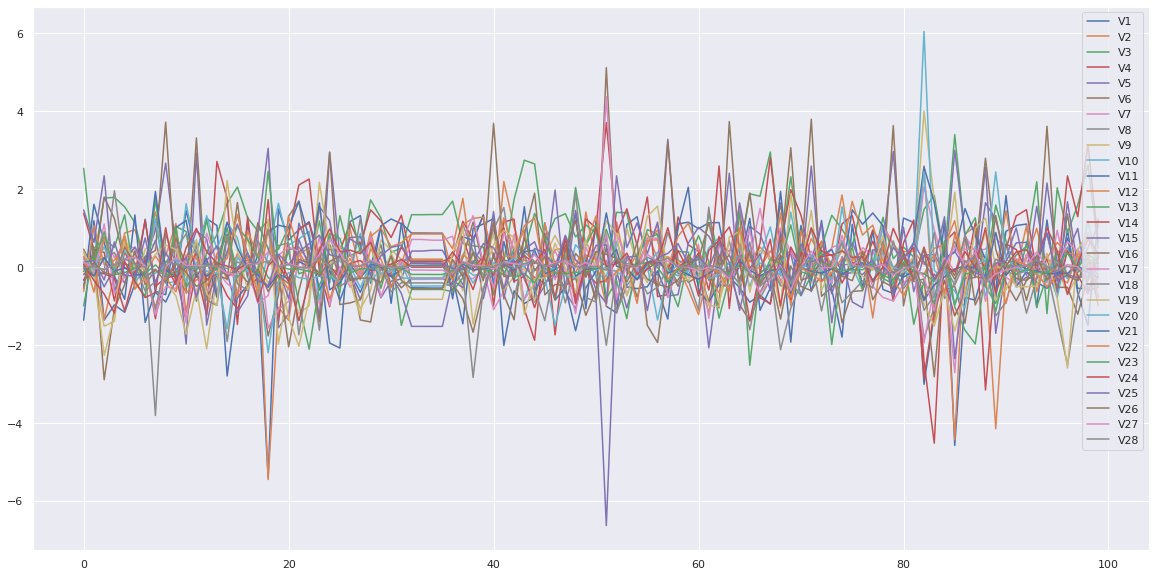

In [11]:
sns.set()
df[anonymous_feaures].iloc[0:100].plot(figsize=(20, 10))
plt.show()

Most out feature are observed to be cantered around zero

### Distribution of amount

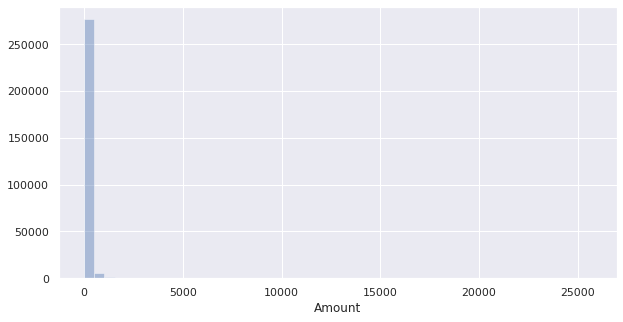

In [12]:
plt.figure(figsize=(10, 5))
sns.distplot(df['Amount'], kde=False)
plt.show()

### Class imbalance in dataset

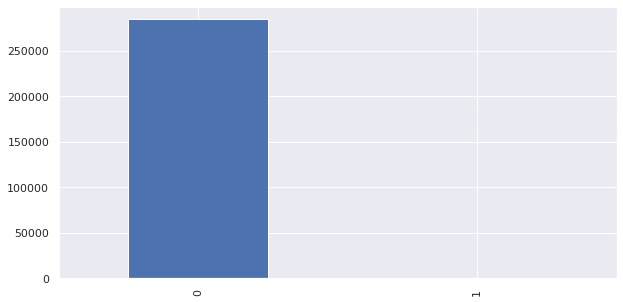

In [13]:
sns.set()
df['Class'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.show()

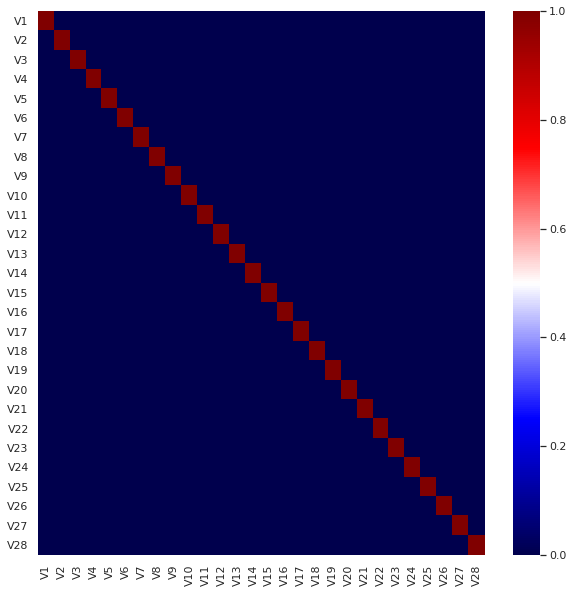

In [14]:
##obserbation anonymous feaures by correlation matrix  
fig = plt.figure(figsize=(10, 10))
sns.heatmap(df[anonymous_feaures].corr(), cmap='seismic')
plt.show()

The above figure shows that the anonymous components in the dataset are highly uncorrelated and there is a good chance of them coming from the result of a PCA analysis.

###Genaral out put 


* The dataset was created using Pytorch Vs panda libraries
* The data is highly unbalanced
* The data contains only numarical input variable with non missing values
* It was observed that the dataset consists of a total of 284807 entries. Columns were named from V1 – V28 and were anonymized due to the sensitive nature of the dataset.
*  

## Dataset creation

In [17]:
class CreditCardFaudDetectionDataset(Dataset):
  """
  Custom class for dataset
  """
  def __init__(self, file_path=None, **kwargs):
    super().__init__(**kwargs)

    if not file_path:
      self.file_path = 'https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv'

    self.df = pd.read_csv(self.file_path)

    self.anonymous_feaures = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
          'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
    self.time = ['Time']
    self.amount = ['Amount']
    self.fraud_non_fraud = ['Class']
    
    self.half_window_size = 64
    dfs = []
    for index in self.df.index[self.df['Class'] == 1]:
      lb = max(0, index - self.half_window_size)
      ub = min(index + self.half_window_size, len(df))
      window_df = df.iloc[lb:ub]
      dfs.append(window_df)

    self.df = pd.concat(dfs, ignore_index=True)
    self.n_entries = len(self.df)

    self.inputs = anonymous_feaures + amount
    self.outputs = fraud_non_fraud

    self.input_indices = [ self.df.columns.get_loc(column) for column in self.inputs ]
    self.output_indices = [ self.df.columns.get_loc(column) for column in self.outputs ]

    self.mapper = self.df['Class'].value_counts()
    self.mapper = (sum(self.mapper) - self.mapper) / sum(self.mapper)
    self.mapper = self.mapper / self.mapper.min()
    self.mapper = self.mapper ** 2
    self.df['weight'] = self.df['Class'].map(self.mapper)

    self.weight_indices = [ self.df.columns.get_loc('weight') ]

  def __len__(self):
      return self.n_entries

  def set_train(self):
      self.train = True

  def set_eval(self):
      self.train = False

  def __getitem__(self, index):
      x = self.df.iloc[index : index + 1, self.input_indices].values
      y = self.df.iloc[index : index + 1, self.output_indices].values
      weights = self.df.iloc[index : index + 1, self.weight_indices].values
      
      return { 'x': x, 'y': y, 'weights': weights }

In [18]:
dataset = CreditCardFaudDetectionDataset()
batch_size = 64
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
dataloader_args = dict(shuffle=False, batch_size=batch_size, num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=False, batch_size=batch_size)
data_loader = torch.utils.data.DataLoader(dataset, **dataloader_args, drop_last=True)

####cross validation and  model selection

In [18]:
k_folds = 3
train_split = 0.9
validation_split = 1 - train_split
k_fold_split = validation_split / k_folds
k_fold_count = round(k_fold_split * len(dataset))
k_fold_splits = [k_fold_count] * k_folds

train_count = len(dataset) - sum(k_fold_splits)
print(f'Found {train_count} train entries, {k_folds} K-fold {k_fold_count} entries')

Found 56679 train entries, 3 K-fold 2099 entries


In [19]:
datasets = torch.utils.data.random_split(dataset, [train_count] + k_fold_splits)
train_dataset = datasets[0]
test_datasets = datasets[1:]
train_dataloader = DataLoader(train_dataset, **dataloader_args)
test_dataloaders = [DataLoader(test_dataset, **dataloader_args) for test_dataset in test_datasets]

In [20]:
data_iter = iter(data_loader)
batch = next(data_iter)

x = batch['x']
y = batch['y']
weights = batch['weights']

x.size(), y.size(), weights.size()

(torch.Size([64, 1, 29]), torch.Size([64, 1, 1]), torch.Size([64, 1, 1]))

## Logistic regression Data Modaling 

In [36]:
X = dataset.df[inputs].values
y = dataset.df[outputs].values.flatten()

In [37]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

## Model creation

In [24]:

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, verbose=1, multi_class='ovr')
clf.fit(X_train, y_train)
y_score = clf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished


## Model evaluation

In [25]:

from sklearn.metrics import classification_report
print(classification_report(y_test, y_score))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6229
           1       0.91      0.62      0.74        69

    accuracy                           1.00      6298
   macro avg       0.96      0.81      0.87      6298
weighted avg       0.99      1.00      0.99      6298



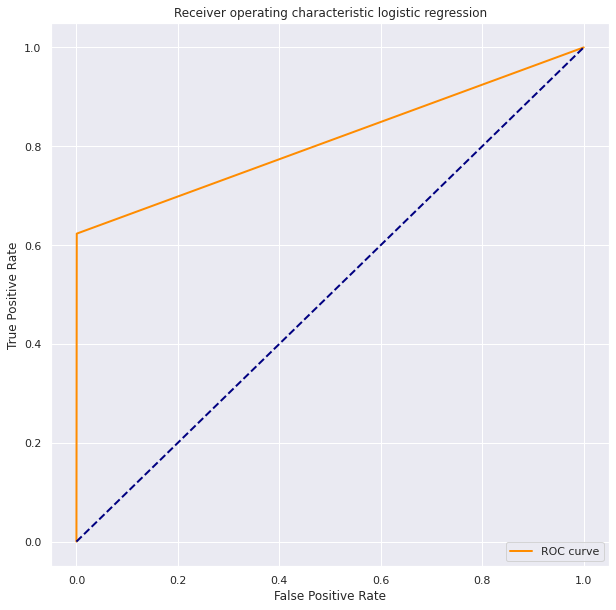

In [26]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
fpr, tpr, _ = roc_curve(y_test, y_score)
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic logistic regression')
plt.legend(loc="lower right")
plt.show()

## Random forests

In [27]:
X = dataset.df[inputs]
y = dataset.df[outputs[0]]

In [28]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

Model creation

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier(n_estimators=10, random_state=0, verbose=1)
clf.fit(X_train, y_train)
y_score = clf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


Model evaluation

In [34]:
from sklearn.metrics import accuracy_score
print(classification_report(y_test, y_score))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6229
           1       0.96      0.68      0.80        69

    accuracy                           1.00      6298
   macro avg       0.98      0.84      0.90      6298
weighted avg       1.00      1.00      1.00      6298



##### Model visualization

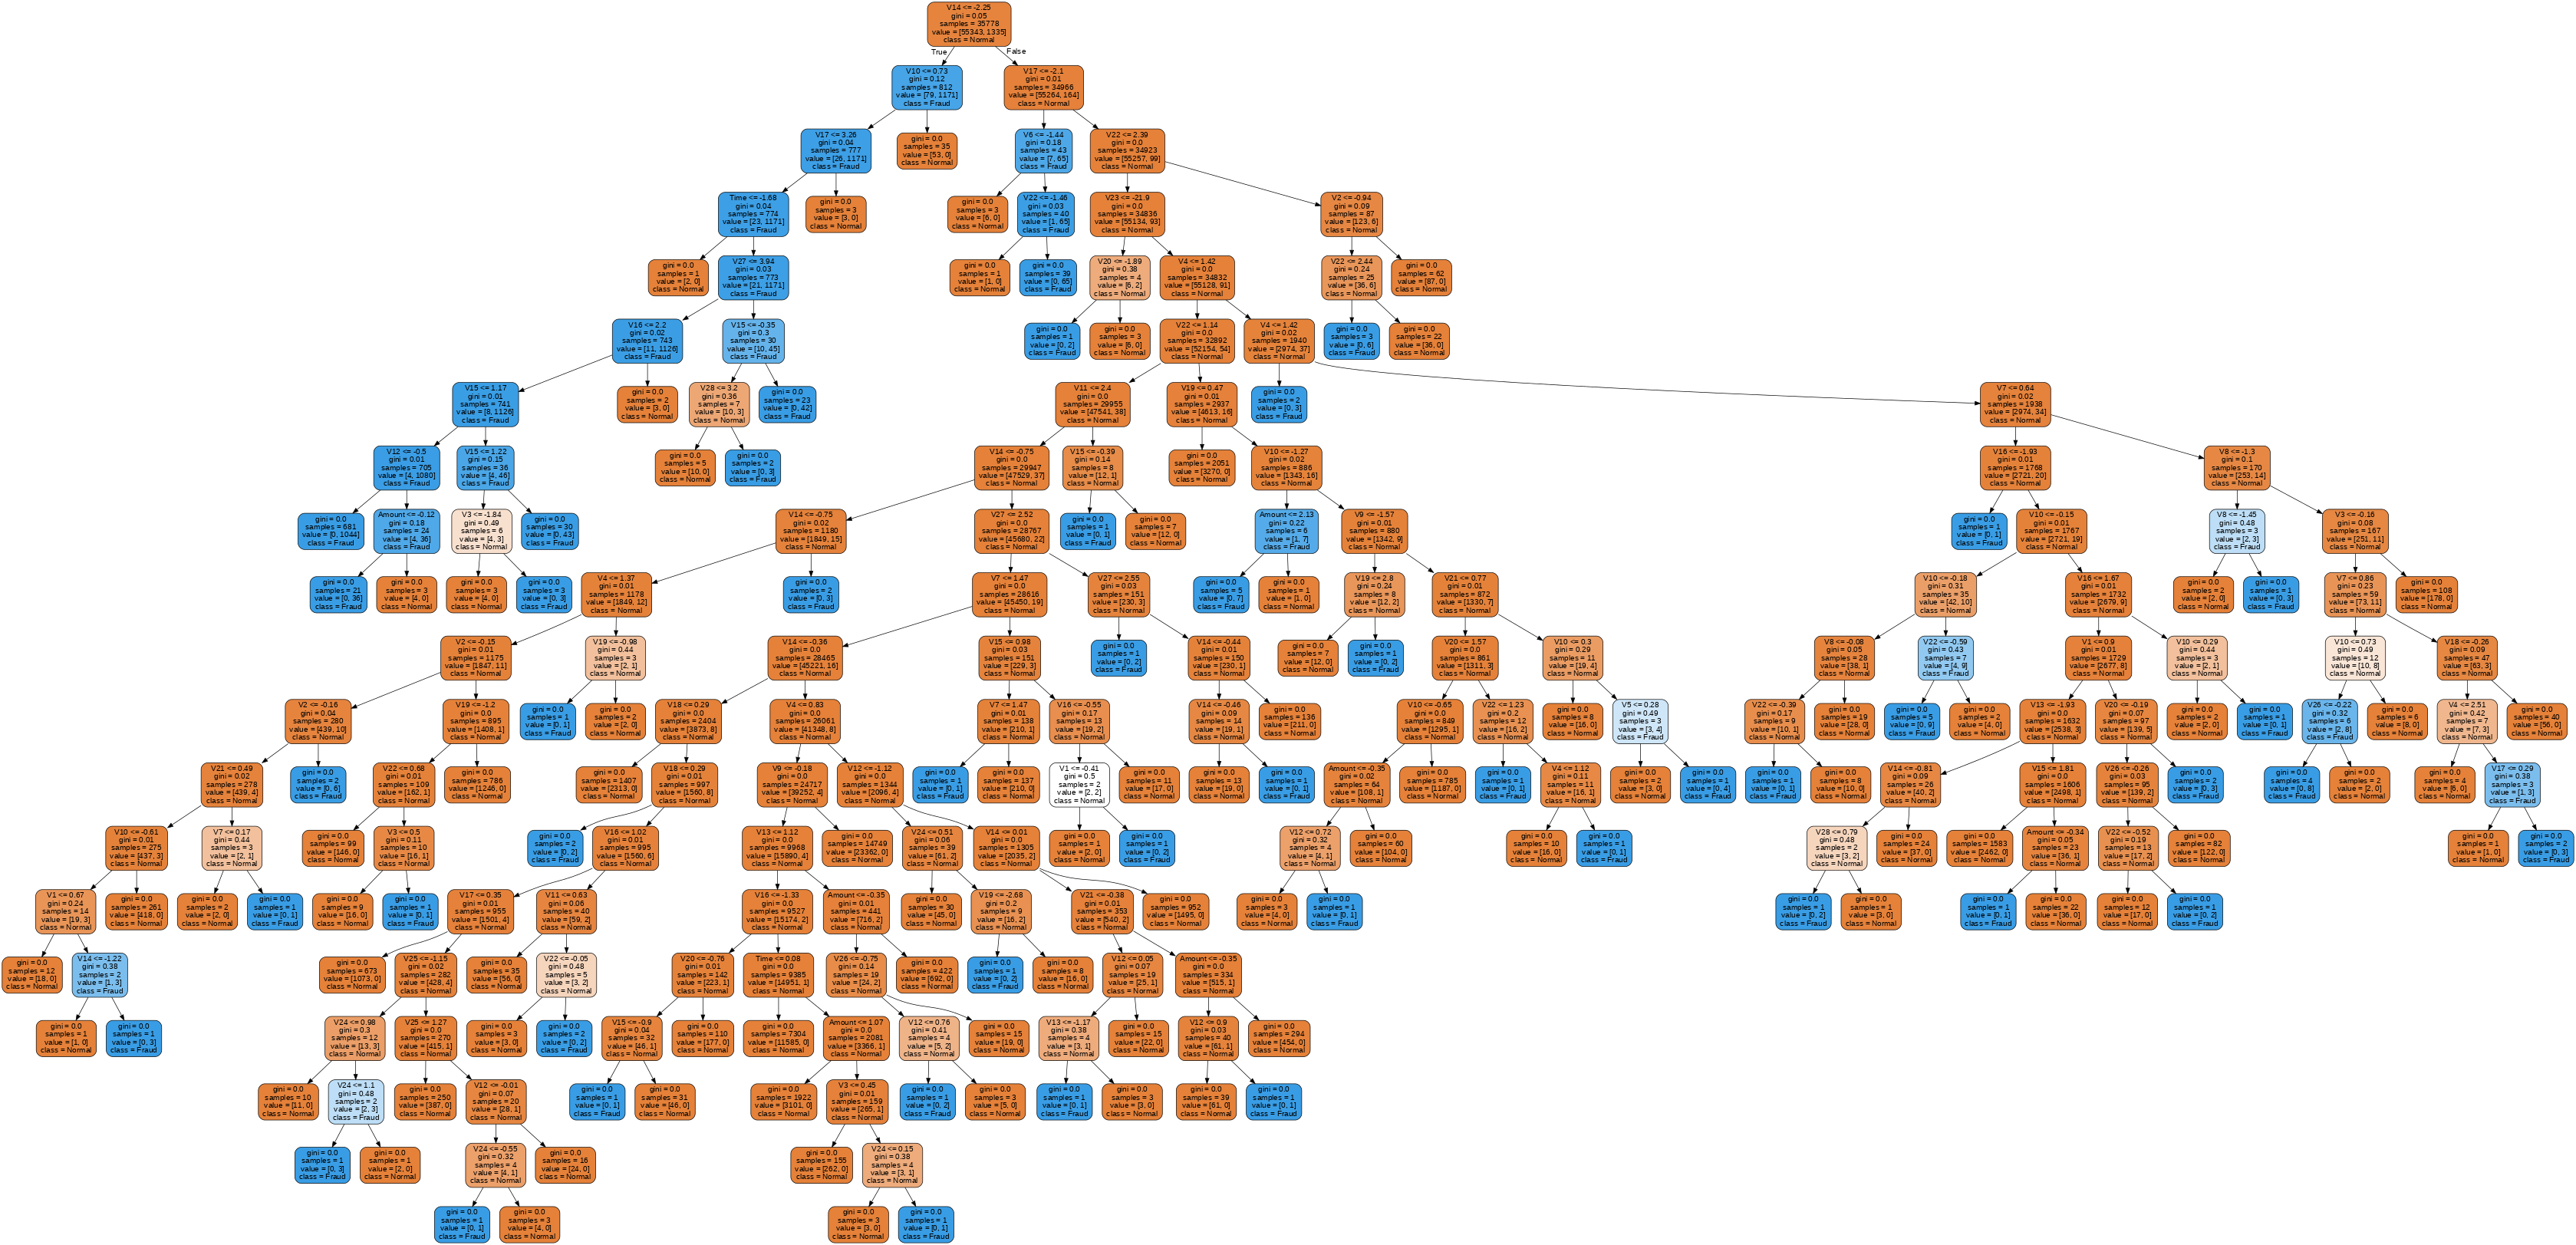

In [35]:
estimator = clf.estimators_[5]

from sklearn.tree import export_graphviz

export_graphviz(estimator, out_file='tree.dot', 
                feature_names = inputs,
                class_names = ['Normal', 'Fraud'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=50'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

 10 destion tree were used to creat the randum forest model with gini score as the information matrics 

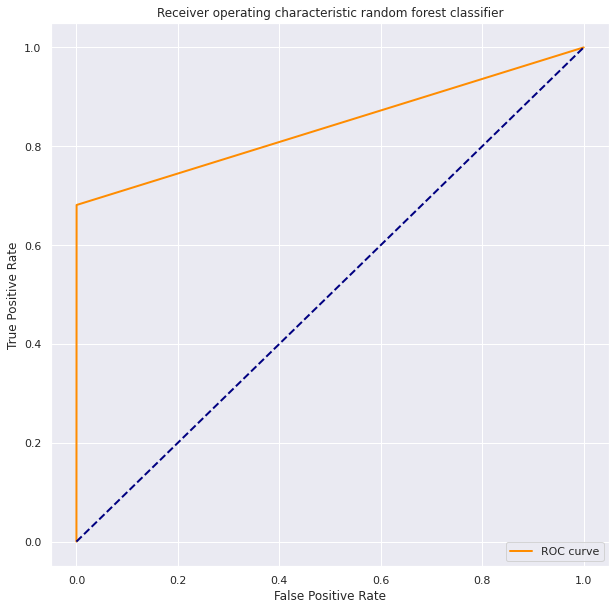

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_score)
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic random forest classifier')
plt.legend(loc="lower right")
plt.show()

### Artificial neural networks


In [ ]:
datasets = torch.utils.data.random_split(dataset, [train_count] + k_fold_splits)
train_dataset = datasets[0]
test_datasets = datasets[1:]
train_dataloader = DataLoader(train_dataset, **dataloader_args)
test_dataloaders = [DataLoader(test_dataset, **dataloader_args) for test_dataset in test_datasets]

In [ ]:
data_iter = iter(data_loader)
batch = next(data_iter)

x = batch['x']
y = batch['y']
weights = batch['weights']

x.size(), y.size(), weights.size()

(torch.Size([64, 1, 29]), torch.Size([64, 1, 1]), torch.Size([64, 1, 1]))

#### Model Creation For Neural Networking

In [ ]:
# Subclassing nn.Module for neural networks
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # _droput = 0.00
        #########################################################################################
        # INPUT BLOCK
        #########################################################################################
        self.double_conv_down0 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=8, kernel_size=(3), padding=(1), bias=False),
            nn.BatchNorm1d(8), 
            nn.ReLU(),
            nn.Conv1d(in_channels=8, out_channels=8, kernel_size=(3), padding=(1), bias=False),
            nn.BatchNorm1d(8), 
            nn.ReLU()
            # nn.Dropout(_droput)
        )
        self.pool0 = nn.Sequential(
            nn.MaxPool1d(2)
        )
        
        #########################################################################################
        # DOUBLE CONVOLUTION BLOCK DOWN 1
        #########################################################################################
        self.double_conv_down1 = nn.Sequential(
            nn.Conv1d(in_channels=8, out_channels=8, kernel_size=(3), padding=(1), bias=False),
            nn.BatchNorm1d(8), 
            nn.ReLU(),
            nn.Conv1d(in_channels=8, out_channels=8, kernel_size=(3), padding=(1), bias=False),
            nn.BatchNorm1d(8), 
            nn.ReLU()
            # nn.Dropout(_droput)
        )
        self.pool1 = nn.Sequential(
            nn.MaxPool1d(2)
        )
        
        #########################################################################################
        # DOUBLE CONVOLUTION BLOCK DOWN 2
        #########################################################################################
        self.double_conv_down2 = nn.Sequential(
            nn.Conv1d(in_channels=8, out_channels=16, kernel_size=(3), padding=(1), bias=False),
            nn.BatchNorm1d(16), 
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=16, kernel_size=(3), padding=(1), bias=False),
            nn.BatchNorm1d(16), 
            nn.ReLU()
            # nn.Dropout(_droput)
        )
        
        self.pool2 = nn.Sequential(
            nn.MaxPool1d(2)
        )

        #########################################################################################
        # DOUBLE CONVOLUTION BLOCK DOWN 3
        #########################################################################################
        self.double_conv_down3 = nn.Sequential(
            nn.Conv1d(in_channels=16, out_channels=16, kernel_size=(3), padding=(1), bias=False),
            nn.BatchNorm1d(16), 
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=16, kernel_size=(3), padding=(1), bias=False),
            nn.BatchNorm1d(16), 
            nn.ReLU()
            # nn.Dropout(_droput)
        )

        self.pool3 = nn.Sequential(
            nn.MaxPool1d(2)
        )

        #########################################################################################
        # GAP
        #########################################################################################
        self.channel_aggregation_gap = nn.AvgPool1d(kernel_size=(3))

        #########################################################################################
        # MAIN HEAD
        #########################################################################################
        self.predictor = nn.Sequential(
            nn.Conv1d(in_channels=16, out_channels=1, kernel_size=(1), bias=False),
            # nn.BatchNorm2d(256),
            # nn.ReLU(),
            # nn.Dropout(_droput)
        )

    def blocks(self, x):

        conv0 = self.double_conv_down0(x)
        x = self.pool0(conv0)

        conv1 = self.double_conv_down1(x)
        x = self.pool1(conv1) 

        conv2 = self.double_conv_down2(x)
        x = self.pool2(conv2) 

        x = self.double_conv_down3(x)

        x = self.channel_aggregation_gap(x)
        
        # Predictor
        x = self.predictor(x)

        return x

    def forward(self, x):
        
        x1 = self.blocks(x)
        
        return x1

In [ ]:
model = Net()
summary(model, input_size=(1, 30), batch_size=4, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                 [4, 8, 30]              24
       BatchNorm1d-2                 [4, 8, 30]              16
              ReLU-3                 [4, 8, 30]               0
            Conv1d-4                 [4, 8, 30]             192
       BatchNorm1d-5                 [4, 8, 30]              16
              ReLU-6                 [4, 8, 30]               0
         MaxPool1d-7                 [4, 8, 15]               0
            Conv1d-8                 [4, 8, 15]             192
       BatchNorm1d-9                 [4, 8, 15]              16
             ReLU-10                 [4, 8, 15]               0
           Conv1d-11                 [4, 8, 15]             192
      BatchNorm1d-12                 [4, 8, 15]              16
             ReLU-13                 [4, 8, 15]               0
        MaxPool1d-14                  [

The abave step help provide the information it can be observed that there is a total of 29 layers with approximately 3500 trainable parameters that make up the neural network.  

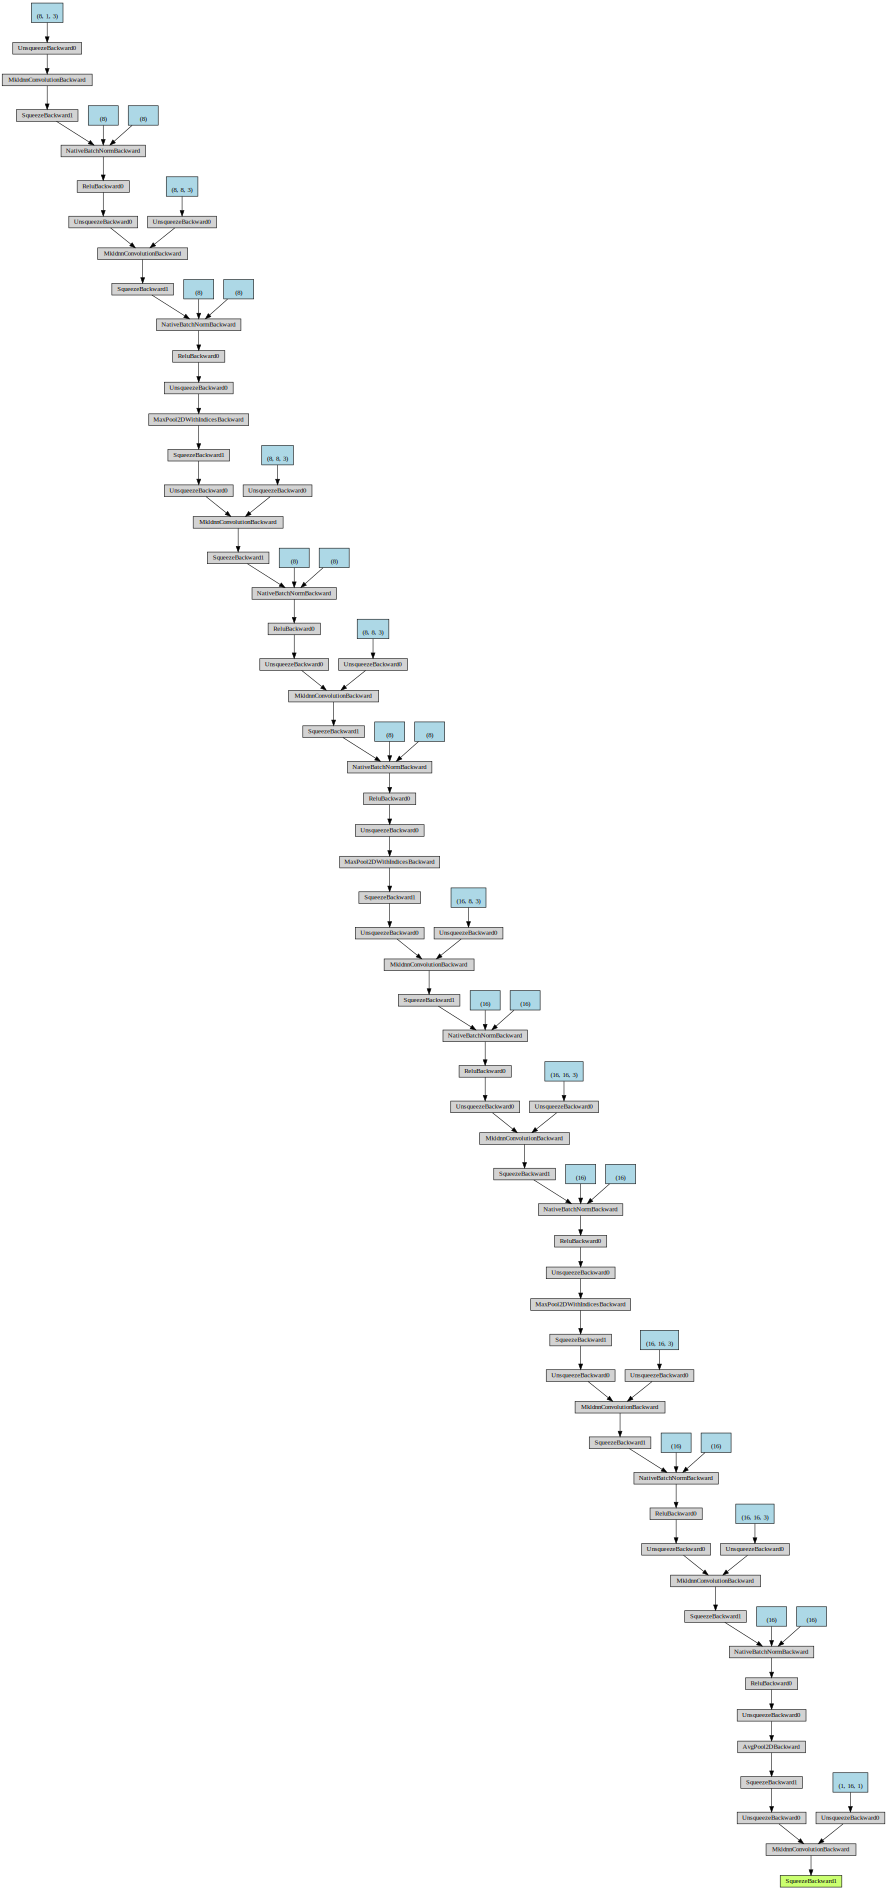

In [ ]:
random_input = torch.randn(1, 1, 30)
model.eval()
y = model(Variable(random_input))
dot_graph = make_dot(y)
dot_graph.format = 'svg'
dot_graph.render(f'{experiment_name}')
dot_graph

In [ ]:
def train(model, device, train_loader, optimizer, epoch, scheduler=None):
    model.train()
    dataset.set_train()
    train_loss = 0
    pbar = tqdm(train_loader)
    train_len = len(train_loader.dataset)
    n_train_batches = np.ceil(train_len / batch_size)

    train_loss, acc = 0, 0

    y_pred = []
    y_true = []

    for batch_idx, batch in enumerate(pbar):
        x = batch['x']
        y = batch['y']
        weights = batch['weights']

        # Move data to cpu/gpu based on input
        x = x.float().to(device)
        target = y.float().to(device)
        weights = weights.float().to(device)

        optimizer.zero_grad()

        # Forward pass
        output = model(x)

        # Loss computation
        bcc_loss = F.binary_cross_entropy_with_logits(output, target, weight=weights, reduction='none').mean()

        # Accuracy
        y_pred_batch = (torch.sigmoid(output) > 0.5).float()
        y_true_batch = target
        comparison = y_pred_batch.eq(y_true_batch).float()

        acc += (comparison.mean() / n_train_batches).item()

        y_pred.extend(torch.flatten(y_pred_batch).cpu().numpy())
        y_true.extend(torch.flatten(y_true_batch).cpu().numpy())
        
        total_loss =  bcc_loss

        batch_loss = total_loss
        train_loss += (batch_loss / n_train_batches).item()
        
        # Backward pass)
        batch_loss.backward()
        
        # Gradient descent
        optimizer.step()

        # Step scheduler if scheduler is present
        if scheduler:
            scheduler.step()
        
        # Logging - updating progress bar and summary writer
        if batch_idx == n_train_batches - 1:
          roc = roc_auc_score(y_true, y_pred)
          pbar.set_description(desc= f'TRAIN : epoch={epoch} total_loss: {total_loss:4f} accuracy: {acc:4f} roc_auc_score {roc:4f}')
        else:
          pbar.set_description(desc= f'TRAIN : epoch={epoch} total_loss: {total_loss:4f} accuracy: {acc:4f}')

    return train_loss, acc, roc, y_pred, y_true

In [ ]:
def test(model, device, test_loader, epoch):

    model.eval()
    dataset.set_eval()
    pbar = tqdm(test_loader)
    test_len = len(test_loader.dataset)
    n_test_batches = np.ceil(test_len / batch_size)
    
    test_loss, acc = 0, 0

    y_pred = []
    y_true = []

    for batch_idx, batch in enumerate(pbar):
        x = batch['x']
        y = batch['y']
        weights = batch['weights']

        # Move data to cpu/gpu based on input
        x = x.float().to(device)
        target = y.float().to(device)
        weights = weights.float().to(device)

        # Forward pass
        output = model(x)

        # Loss computation
        bcc_loss = F.binary_cross_entropy_with_logits(output, target, weight=weights, reduction='none').mean()

        # Accuracy
        y_pred_batch = (torch.sigmoid(output) > 0.5).float()
        y_true_batch = target
        comparison = y_pred_batch.eq(y_true_batch).float()

        acc += (comparison.mean() / n_test_batches).item()

        y_pred.extend(torch.flatten(y_pred_batch).cpu().numpy())
        y_true.extend(torch.flatten(y_true_batch).cpu().numpy())
        
        total_loss =  bcc_loss

        batch_loss = total_loss
        test_loss += (batch_loss / n_test_batches).item()

        # Logging - updating progress bar and summary writer
        if batch_idx == n_test_batches - 1:
          roc = roc_auc_score(y_true, y_pred)
          pbar.set_description(desc= f'TEST : epoch={epoch} total_loss: {total_loss:4f} accuracy: {acc:4f} roc_auc_score {roc:4f}')        
        else:
          pbar.set_description(desc= f'TEST : epoch={epoch} epoch={epoch} total_loss: {total_loss:4f} accuracy: {acc:4f}')

    return test_loss, acc, roc, y_pred, y_true

In [ ]:
model = Net()
model = model.to(device)

In [ ]:
lr = 1e-3
epochs = 30
momentum = 0.9

optimizer = optim.Adam(model.parameters(), lr=lr, amsgrad=True)

best_test_accuracy = 0
best_test_loss = float('inf')
best_model_path = ''

test_summary = {}
train_summary = {}

test_summary['loss'] = {}
train_summary['loss'] = {}

test_summary['accuracy'] = {}
train_summary['accuracy'] = {}

test_summary['roc'] = {}
train_summary['roc'] = {}


for epoch in range(0, epochs):
    
    train_loss, train_accuracy, train_roc, train_y_pred, train_y_true = train(model, device, train_dataloader, optimizer, epoch, scheduler=None)

    train_summary['loss'][f'epoch_{epoch}'] = train_loss
    train_summary['accuracy'][f'epoch_{epoch}'] = train_accuracy
    train_summary['roc'][f'epoch_{epoch}'] = train_roc

    test_accuracies = []
    test_losses = []
    test_rocs = []

    for test_dataloader in test_dataloaders:
      test_loss, test_accuracy, test_roc, test_y_pred, test_y_true = test(model, device, test_dataloader, epoch)
      test_accuracies.append(test_accuracy)
      test_losses.append(test_loss)
      test_rocs.append(test_rocs)
    
    test_summary['loss'][f'epoch_{epoch}'] = test_losses
    test_summary['accuracy'][f'epoch_{epoch}'] = test_accuracies
    test_summary['roc'][f'epoch_{epoch}'] = test_rocs

TRAIN : epoch=0 total_loss: 1.354116 accuracy: 0.620742 roc_auc_score 0.795555: 100%|██████████| 886/886 [02:16<00:00,  6.50it/s]
TEST : epoch=0 total_loss: 1.147004 accuracy: 0.687704 roc_auc_score 0.841239: 100%|██████████| 33/33 [00:04<00:00,  7.29it/s]
TEST : epoch=0 total_loss: 31.119200 accuracy: 0.670306 roc_auc_score 0.810712: 100%|██████████| 33/33 [00:04<00:00,  7.29it/s]
TEST : epoch=0 total_loss: 1.750392 accuracy: 0.653595 roc_auc_score 0.822754: 100%|██████████| 33/33 [00:04<00:00,  7.54it/s]
TRAIN : epoch=1 total_loss: 1.260009 accuracy: 0.420177 roc_auc_score 0.699491: 100%|██████████| 886/886 [02:15<00:00,  6.56it/s]
TEST : epoch=1 total_loss: 0.938052 accuracy: 0.569918 roc_auc_score 0.781220: 100%|██████████| 33/33 [00:05<00:00,  6.56it/s]
TEST : epoch=1 total_loss: 2.916187 accuracy: 0.570382 roc_auc_score 0.780107: 100%|██████████| 33/33 [00:04<00:00,  6.75it/s]
TEST : epoch=1 total_loss: 0.982147 accuracy: 0.564812 roc_auc_score 0.777100: 100%|██████████| 33/33 [0

####Model evaluation

In [ ]:
train_summary_df = pd.DataFrame(train_summary)

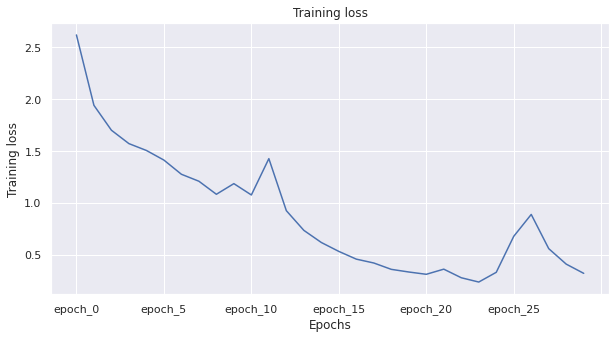

In [ ]:
ax = train_summary_df['loss'].plot(figsize=(10, 5), title='Training loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Training loss')
plt.show()

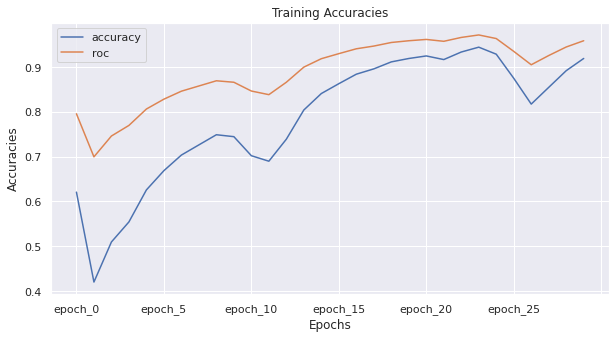

In [ ]:
ax = train_summary_df[['accuracy', 'roc']].plot(figsize=(10, 5), title='Training Accuracies')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracies')
plt.show()

we can observe hear the ROC more perform than the accuracy 

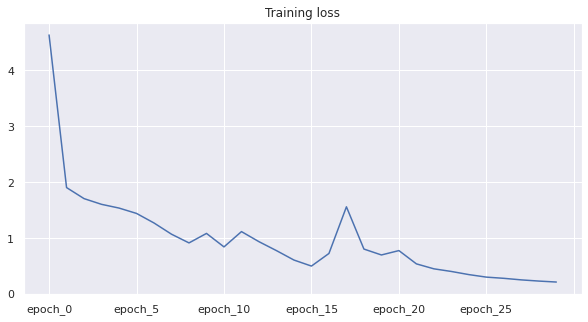

In [ ]:
train_summary_df['loss'].plot(figsize=(10, 5), title='Training loss')
plt.show()

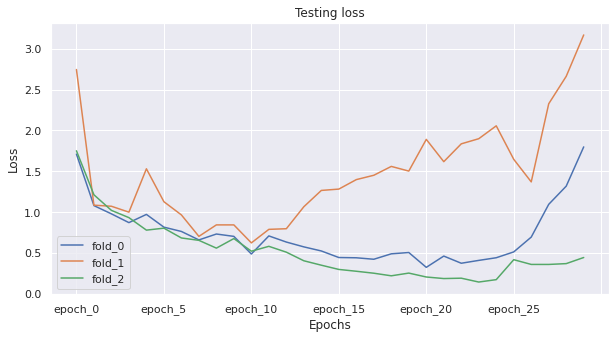

In [ ]:
test_loss_df = pd.DataFrame(test_summary['loss']).transpose()
test_loss_df.columns =  [f'fold_{fold}' for fold in range(k_folds)]

ax = test_loss_df.plot(figsize=(10, 5), title='Testing loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.show()

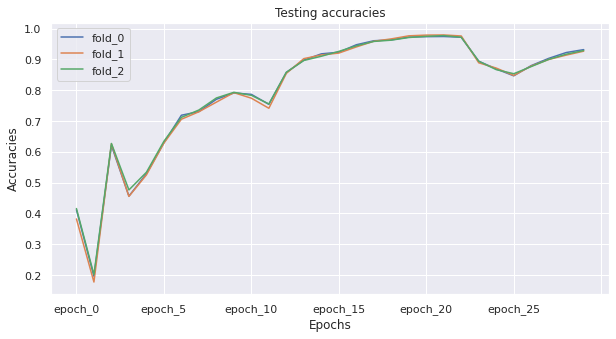

In [ ]:
test_acc_df = pd.DataFrame(test_summary['accuracy']).transpose()
test_acc_df.columns =  [f'fold_{fold}' for fold in range(k_folds)]

ax = test_acc_df.plot(figsize=(10, 5), title='Testing accuracies')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracies')
plt.show()

Test accuracies for the different k-fold splits across different epochs are plotted above.

##conclusion

The result that has been concluded that for the implementation of Logistic regression provides a very simple, fast, and highly interpretable model for predicting credit card fraud detection. Random forests provide a better model than anyone with medium interpretability and reasonable metrics (accuracy, precision, and recall) at a marginal computation resource. The result that has been concluded that for the implementation of logistic regression, it observed that even though the accuracy of the model is high (~ 99%), the recall score for fraudulent cases is (~ 62%). This is a direct effect of the heavy class imbalance present in the dataset that finally manifests as the inability to understand the minority class. Random forest is very similar to logistic regression, it can be noted that even though the accuracy of the model is very high (~100%), the recall score for fraudulent cases is low (approx 68%). This is a direct effect of the heavy class imbalance present in the dataset, which finally manifests as the inability to understand the minority class. Besides.
Artificial neural networks give a complicated model at par with random forests but can be fine-tuned to any extent with very low interpretability. Best recall scores but comes at a computational cost, also finally reach an accuracy of 95% on the dataset with a very high recall score of 97%, however, it took an hour to get the result.
 In future work, I aim to improve the accuracy and processing time of the financial fraud process in real-time combined with both machine learning-based process and deep artificial neural networks.


##Reference


 1,Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow Third Edition – Includes Tensor-low 2, GANs, and Reinforcement Learning Sebastian Raschka & Vahid Mirjalili

2,https://www.geeksforgeeks.org/ml-credit-card-fraud-detection/

3, References1. Credit Card Fraud Detection Based on Transaction Behavior -by JohnRichard D. Kho, Larry A. Vea published by Proc. of the 2017 IEEERegion 10 Conference (TENCON), Malaysia, November 5-8, 2017

4,https://scikit-learn.org/stable/modules/generated/sklearn.

5,linear_model.LogisticRegression.html

6,https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.

7,RandomForestClassifier.html

8,https://scikit-learn.org/stable/modules/generated/sklearn.

9,model_selection.GridSearchCV.html

10,https://scikit-learn.org/stable/modules/generated/sklearn.tree.

11,DecisionTreeClassifier.html

12,https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.

13,VotingClassifier.html

14,https://www.datacamp.com/courses/fraud-detection-in-python

15,https://towardsdatascience.com/

16,how-dbscan-works-and-why-should-i-use-it-443b4a191c80

17,https://scikit-learn.org/stable/modules/generated/sklearn.cluster.

18,DBSCAN.html
19,https://towardsdatascience.com/pytorch-layer-dimensions-what-sizes-should-they-be-and-why-4265a41e01fd
